# Sea surface temperature: outlook time-series
----

J. Potemra<br>
February 2024

----
This notebook will access sea surface temperature (SST) from the NOAA Climate Forecast CFSv2 model and produce a forecast time-series of temperature at a single point.

The CFS version 2 was developed at the Environmental Modeling Center at NCEP. It is a fully coupled model representing the interaction between the Earth's atmosphere, oceans, land and seaice. It became operational at NCEP in March 2011.<sup>1</sup>

In this notebook the data are accessed from the NOAA NOMADS THREDDS server (https://www.ncei.noaa.gov/thredds/catalog/model/model.html).  The output is then found under Climate Forecast System --> CFS Operational 9-Month Forecast Monthly Mean --> then year, month day.  For example, for the nine month forecast from Feb 1, 2024:
https://www.ncei.noaa.gov/thredds/catalog/model-cfs_v2_for_mm/2024/202402/20240201/2024020100/catalog.html

The model is run every day and there are four initializations (at 00, 06, 12, 18 hours).  The files are stored in a TDS catalog within a directory structure by year, then year-month, then year-month-day, then year-month-day-forecast time.  So, for example, the run initialized at 00 on February 1, 2024 would be in a directory 2024/202402/20240201/2024020100.  The file acccessed then has the name ocnh.01.2024020100.202402.avrg.grib.grb2.  This is important as the file access can be scripted.  Here we use a set time, but this could be automatic based on run time.

-------
<sup>1</sup>Saha, Suranjana, and Coauthors, 2010: The NCEP Climate Forecast System Reanalysis. Bull. Amer. Meteor. Soc., 91, 1015.1057. doi: 10.1175/2010BAMS3001.1

## Import needed packages

In [1]:
# data I/O and processing
import xarray as xr
import pandas as pd
import numpy as np

# data plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read data
The data are available on the NOAA THREDDS server.  Here we specify the date of run to access data.


In [2]:
# set initial file by year, month, day
mod_year = '2024'
mod_mon = '02'
mod_day = '01'
mod_hour = '00'
root_url = 'https://www.ncei.noaa.gov/thredds/dodsC/model-cfs_v2_for_mm/'
subdir = mod_year + '/' + mod_year + mod_mon + '/' + mod_year + mod_mon + mod_day + '/' \
       + mod_year + mod_mon + mod_day + mod_hour + '/'

# define url's for OPeNDAP requests; here we read the entire nine-month forecast
url = []
for imon in range(9):
    filename = 'ocnh.01.' + mod_year + mod_mon + mod_day + mod_hour + '.' + mod_year \
             + str(imon+int(mod_mon)).zfill(2) + '.avrg.grib.grb2'
    url.append(root_url+subdir+filename)

In [3]:
def get_remote(lon,lat,url):  
    iter = 0
    for imon in range (9):
        ds = xr.open_dataset(url[imon],decode_times=False)['Temperature_surface_1_Month_Average']
        mod_lon = ds['lon'].to_numpy()
        i = np.argmin(np.abs(mod_lon-lon))
        mod_lat = ds['lat'].to_numpy()
        j = np.argmin(np.abs(mod_lat-lat))
        ds1 = ds[0,j,i]
        ds2 = ds1 if iter==0 else xr.concat([ds2,ds1],dim='time')
        iter += 1
    return ds2

## Define lat/lon/time ranges for analysis and display

In [4]:
# define lat/lon range for Palau
xlon = 134.0
ylat = 7.0

## Read data
Note the data is not read until "needed."  Data access may take a while since we're loading from a remote server. 

In [5]:
# do a remote OPeNDAP read

sst = get_remote(xlon,ylat,url)

## Make a plot
Make a time-series plot of "predicted" SST from the CSFv2 

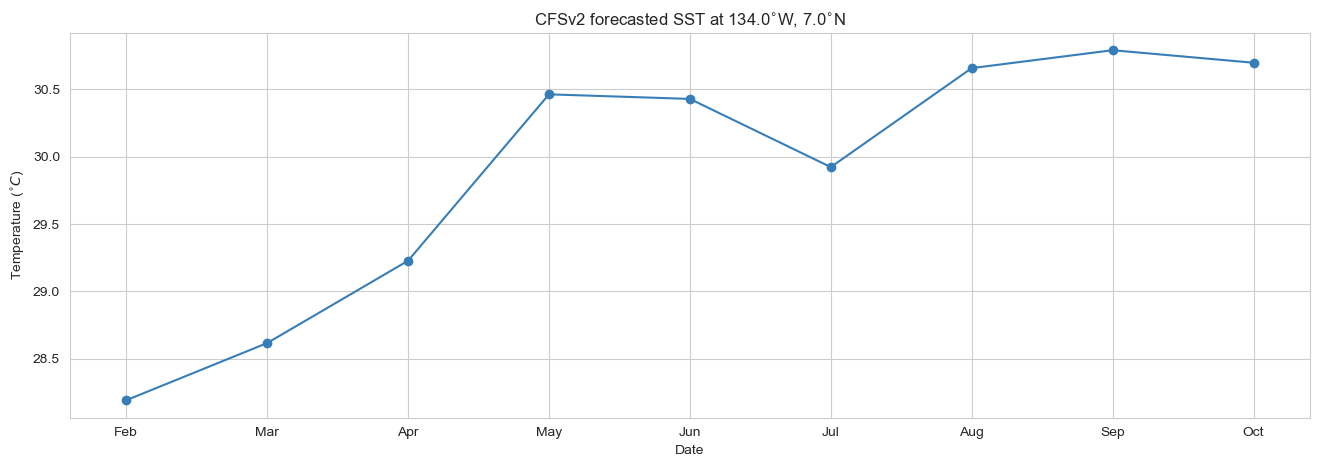

In [6]:
# define the time axis
cmon = ['Jan','Feb','Mar','Apr','May','Jun',
        'Jul','Aug','Sep','Oct','Nov','Dec']
mon1 = int(mod_mon)
time = np.arange(9)
xlab = [ cmon[i+mon1-1] for i in time ]

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,5))
ax.plot(time,sst-273.15,color=palette[1], linestyle='-', marker='o')
ax.set_xticks(time)
ax.set_xticklabels(['Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct'])
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^{\circ}C$)')
ax.set_title('CFSv2 forecasted SST at ' + str(xlon) + '$^{\circ}$W, ' + str(ylat) + '$^{\circ}$N')

plt.savefig('images/temp_outlook_ts.png')